# Data Exploration - Phase II
Shpaner, Leonid  
Robinson, Christopher  
Luis-Estrada, Jose  

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library

/content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library


In [3]:
####################################
## import the requisite libraries ##
####################################
import os
import csv
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import stats models for q-q plots and 
# baseline logistic regression
import statsmodels.api as sm

import warnings
# suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# suppress future warnings for cleaner output
warnings.filterwarnings(action='ignore', category=FutureWarning)

# import modeling libraries
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, mean_squared_error,\
precision_score, recall_score, f1_score, accuracy_score,\
confusion_matrix, plot_confusion_matrix, classification_report

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# check current working directory
current_directory = os.getcwd()
current_directory

'/content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library'

### Assign Paths to Folders

In [5]:
# path to data folder
data_path1 = '/content/drive/Shareddrives/Capstone - Best Group/navigating_crime/'\
             'Data Folder/'

# path to the training file
data_path2 = '/content/drive/Shareddrives/Capstone - Best Group/navigating_crime/'\
             'Data Folder/train_set.csv'

# path to the validation file
data_path3 = '/content/drive/Shareddrives/Capstone - Best Group/navigating_crime/'\
             'Data Folder/valid_set.csv'             

# path to the image library
image_path = '/content/drive/Shareddrives/Capstone - Best Group/navigating_crime'\
          + '/Image Folder'        

In [6]:
# bring in original dataframe only for join purposes
train_set = pd.read_csv(data_path2).set_index('OBJECTID')
valid_set = pd.read_csv(data_path3).set_index('OBJECTID')

In [7]:
train_set.shape

(128205, 15)

In [8]:
valid_set.shape

(27472, 15)

In [9]:
train_set.head()

,Zip_Code,Accuracy,Crime_Cost,StreetOID,DR_NO,TIME_OCC,AREA,Part_1_2,Vict_Age,Premis_Cd,Weapon_Used_Cd,Days_Disclosure,Street_Type,Gender,Crime_Code
OBJECTID,,,,,,,,,,,,,,,
69772,90024.0,50.0,2.0,27815,210814900.0,750.0,8.0,2.0,40.0,102.0,400.0,0,7,1,0
131641,90037.0,50.0,3.0,51117,210313311.0,1100.0,3.0,1.0,32.0,101.0,106.0,0,8,2,0
143866,90016.0,50.0,1.0,55526,200705585.0,1420.0,7.0,1.0,46.0,101.0,102.0,0,7,2,1
189323,90003.0,50.0,0.0,72325,221213641.0,910.0,12.0,2.0,25.0,102.0,400.0,0,8,1,0
89956,91331.0,50.0,2.0,35427,221606939.0,1625.0,16.0,2.0,63.0,108.0,400.0,0,6,2,0


In [10]:
valid_set.head()

,Zip_Code,Accuracy,Crime_Cost,StreetOID,DR_NO,TIME_OCC,AREA,Part_1_2,Vict_Age,Premis_Cd,Weapon_Used_Cd,Days_Disclosure,Street_Type,Gender,Crime_Code
OBJECTID,,,,,,,,,,,,,,,
139967,91303.0,50.0,12.0,54070,212112846.0,2330.0,21.0,1.0,51.0,101.0,212.0,5,7,1,0
195729,90036.0,50.0,31.0,74593,200710514.0,1430.0,7.0,2.0,0.0,101.0,306.0,0,7,2,0
108679,90019.0,50.0,7.0,42567,200708170.0,1840.0,7.0,1.0,29.0,101.0,102.0,0,7,2,1
195632,90017.0,50.0,0.0,74587,200210025.0,1015.0,2.0,1.0,27.0,102.0,200.0,0,6,2,1
125869,90001.0,50.0,0.0,49110,211221718.0,1455.0,12.0,2.0,7.0,101.0,500.0,0,8,1,1


In [11]:
dev_set = pd.concat([train_set, valid_set], axis=0)

In [12]:
dev_set

,Zip_Code,Accuracy,Crime_Cost,StreetOID,DR_NO,TIME_OCC,AREA,Part_1_2,Vict_Age,Premis_Cd,Weapon_Used_Cd,Days_Disclosure,Street_Type,Gender,Crime_Code
OBJECTID,,,,,,,,,,,,,,,
69772,90024.0,50.0,2.0,27815,210814900.0,750.0,8.0,2.0,40.0,102.0,400.0,0,7,1,0
131641,90037.0,50.0,3.0,51117,210313311.0,1100.0,3.0,1.0,32.0,101.0,106.0,0,8,2,0
143866,90016.0,50.0,1.0,55526,200705585.0,1420.0,7.0,1.0,46.0,101.0,102.0,0,7,2,1
189323,90003.0,50.0,0.0,72325,221213641.0,910.0,12.0,2.0,25.0,102.0,400.0,0,8,1,0
89956,91331.0,50.0,2.0,35427,221606939.0,1625.0,16.0,2.0,63.0,108.0,400.0,0,6,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231763,90028.0,50.0,63.0,87819,200615517.0,1830.0,6.0,1.0,59.0,102.0,200.0,0,8,2,0
153244,90065.0,50.0,0.0,58940,221104189.0,130.0,11.0,1.0,19.0,101.0,102.0,0,8,2,1
83795,90017.0,50.0,2.0,33138,210209488.0,1730.0,2.0,1.0,61.0,102.0,200.0,0,6,2,1


In [13]:
X_train = train_set.drop(columns=['Crime_Code'])
y_train = train_set['Crime_Code']

X_val = valid_set.drop(columns=['Crime_Code'])
y_val = valid_set['Crime_Code']

## Logistic Regression

Cost = 0.01 	 Validation Accuracy = 0.94 	     Training Accuracy = 0.93
Cost = 0.10 	 Validation Accuracy = 0.94 	     Training Accuracy = 0.93
Cost = 0.20 	 Validation Accuracy = 0.94 	     Training Accuracy = 0.93
Cost = 0.50 	 Validation Accuracy = 0.94 	     Training Accuracy = 0.93
Cost = 0.80 	 Validation Accuracy = 0.94 	     Training Accuracy = 0.93
Cost = 1.00 	 Validation Accuracy = 0.94 	     Training Accuracy = 0.93
Cost = 5.00 	 Validation Accuracy = 0.94 	     Training Accuracy = 0.93
Cost = 10.00 	 Validation Accuracy = 0.94 	     Training Accuracy = 0.93
Cost = 20.00 	 Validation Accuracy = 0.94 	     Training Accuracy = 0.93
Cost = 50.00 	 Validation Accuracy = 0.94 	     Training Accuracy = 0.93


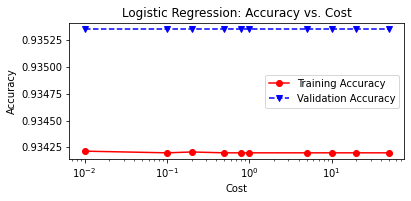

In [14]:
# Manually Tuning The Logistic Regression Model
C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
LRtrainAcc = []
LRvalAcc = []
for param in C:
    tuned_lr = LogisticRegression(solver = 'liblinear',
                                  C = param,
                                  max_iter = 500,
                                  penalty = 'l1',
                                  n_jobs = -1,
                                  random_state = 222)
    tuned_lr.fit(X_train, y_train)
    # Predict on train set
    tuned_lr_pred_train = tuned_lr.predict(X_train)
    # Predict on val set
    tuned_lr1 = tuned_lr.predict(X_val)
    LRtrainAcc.append(accuracy_score(y_train, tuned_lr_pred_train))
    LRvalAcc.append(accuracy_score(y_val, tuned_lr1))
    print('Cost = %2.2f \t Validation Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (param,accuracy_score(y_val,tuned_lr1),
                               accuracy_score(y_train,tuned_lr_pred_train)))

# plot cost by accuracy
fig, ax = plt.subplots(figsize=(6,2.5))
ax.plot(C, LRtrainAcc, 'ro-', C, LRvalAcc,'bv--')
ax.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Logistic Regression: Accuracy vs. Cost')
ax.set_xlabel('Cost'); ax.set_xscale('log')
ax.set_ylabel('Accuracy'); plt.show()

In [15]:
# accuracy and classification report (Tuned Model)
print('Tuned Logistic Regression Model')
print('Accuracy Score')
print(accuracy_score(y_val, tuned_lr1))
print('Classification Report \n', 
       classification_report(y_val, tuned_lr1))

Tuned Logistic Regression Model
Accuracy Score
0.9353523587652883
Classification Report 
               precision    recall  f1-score   support

           0       0.99      0.87      0.92     12487
           1       0.90      0.99      0.94     14985

    accuracy                           0.94     27472
   macro avg       0.94      0.93      0.93     27472
weighted avg       0.94      0.94      0.93     27472



In [25]:
X_var = list(X_val.columns)

In [26]:
X_var 

['Zip_Code',
 'Accuracy',
 'Crime_Cost',
 'StreetOID',
 'DR_NO',
 'TIME_OCC',
 'AREA',
 'Part_1_2',
 'Vict_Age',
 'Premis_Cd',
 'Weapon_Used_Cd',
 'Days_Disclosure',
 'Street_Type',
 'Gender']

In [23]:
X_val

,Zip_Code,Accuracy,Crime_Cost,StreetOID,DR_NO,TIME_OCC,AREA,Part_1_2,Vict_Age,Premis_Cd,Weapon_Used_Cd,Days_Disclosure,Street_Type,Gender
OBJECTID,,,,,,,,,,,,,,
139967,91303.0,50.0,12.0,54070,212112846.0,2330.0,21.0,1.0,51.0,101.0,212.0,5,7,1
195729,90036.0,50.0,31.0,74593,200710514.0,1430.0,7.0,2.0,0.0,101.0,306.0,0,7,2
108679,90019.0,50.0,7.0,42567,200708170.0,1840.0,7.0,1.0,29.0,101.0,102.0,0,7,2
195632,90017.0,50.0,0.0,74587,200210025.0,1015.0,2.0,1.0,27.0,102.0,200.0,0,6,2
125869,90001.0,50.0,0.0,49110,211221718.0,1455.0,12.0,2.0,7.0,101.0,500.0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231763,90028.0,50.0,63.0,87819,200615517.0,1830.0,6.0,1.0,59.0,102.0,200.0,0,8,2
153244,90065.0,50.0,0.0,58940,221104189.0,130.0,11.0,1.0,19.0,101.0,102.0,0,8,2
83795,90017.0,50.0,2.0,33138,210209488.0,1730.0,2.0,1.0,61.0,102.0,200.0,0,6,2


In [27]:
lr_pred = pd.DataFrame({'Predictions': tuned_lr.predict_proba(valid_set[X_var])[:, 1]})

In [28]:
tuned_lr_roc = metrics.roc_curve(y_val,lr_pred)
fpr,tpr,thresholds = metrics.roc_curve(y_val,lr_pred)
tuned_lr_auc = metrics.auc(fpr, tpr)
tuned_lr_plot = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr, 
roc_auc = tuned_lr_auc, 
estimator_name = 'Logistic Regression')

In [ ]:
# tuned_lr1 = tuned_lr.predict(X_val)

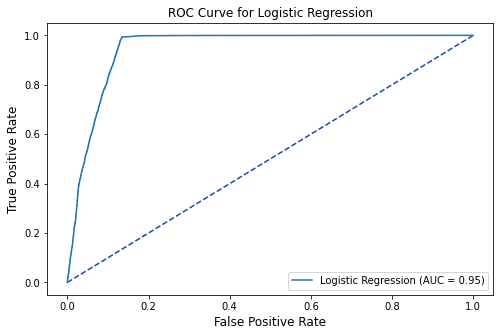

In [29]:
# Model ROC Plots Defined above
# plot set up
fig, ax = plt.subplots(figsize=(8,5))
plt.title('ROC Curve for Logistic Regression',fontsize=12)
plt.plot([0, 1], [0, 1], linestyle = '--', 
         color = '#174ab0')
plt.xlabel('',fontsize=12) 
plt.ylabel('',fontsize=12) 
tuned_lr_plot.plot(ax)
plt.show()

In [30]:
df_predictions = valid_set.copy()

In [31]:
df_predictions

,Zip_Code,Accuracy,Crime_Cost,StreetOID,DR_NO,TIME_OCC,AREA,Part_1_2,Vict_Age,Premis_Cd,Weapon_Used_Cd,Days_Disclosure,Street_Type,Gender,Crime_Code
OBJECTID,,,,,,,,,,,,,,,
139967,91303.0,50.0,12.0,54070,212112846.0,2330.0,21.0,1.0,51.0,101.0,212.0,5,7,1,0
195729,90036.0,50.0,31.0,74593,200710514.0,1430.0,7.0,2.0,0.0,101.0,306.0,0,7,2,0
108679,90019.0,50.0,7.0,42567,200708170.0,1840.0,7.0,1.0,29.0,101.0,102.0,0,7,2,1
195632,90017.0,50.0,0.0,74587,200210025.0,1015.0,2.0,1.0,27.0,102.0,200.0,0,6,2,1
125869,90001.0,50.0,0.0,49110,211221718.0,1455.0,12.0,2.0,7.0,101.0,500.0,0,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231763,90028.0,50.0,63.0,87819,200615517.0,1830.0,6.0,1.0,59.0,102.0,200.0,0,8,2,0
153244,90065.0,50.0,0.0,58940,221104189.0,130.0,11.0,1.0,19.0,101.0,102.0,0,8,2,1
83795,90017.0,50.0,2.0,33138,210209488.0,1730.0,2.0,1.0,61.0,102.0,200.0,0,6,2,1


In [36]:
df_pred = pd.DataFrame({'Predictions': tuned_lr.predict_proba(valid_set[X_var])[:, 1]})

In [37]:
df_pred.to_csv('Preds.csv')

In [33]:
df_predictions = valid_set.join(lr_pred, how='left', lsuffix='left', rsuffix='right')

In [ ]:
valid_set

In [38]:
df_predictions.to_csv('Test2.csv')